In [1]:
import os, json, io
import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.engine import get_iou_types, evaluate
from models.load import get_trained_model
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.paths import MIMIC_EYE_PATH
from tqdm import tqdm
from utils.train import  get_coco_eval_params
from utils.coco_eval import get_eval_params_dict
from data.strs import SourceStrs, TaskStrs
from IPython.display import clear_output
from coco_froc_analysis.froc.froc_curve import get_froc_curve, get_interpolate_froc

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from enum import Enum

class RetrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b0_with_fix = "val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0"
    efficientnet_b0_baseline = "val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0"
    vgg16_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8247_epoch9_04-03-2023 01-53-49_lesion_dsetection_with_fix_vgg16"
    vgg16_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_7991_epoch8_04-03-2023 04-59-07_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix ="val_lesion-detection_froc_0_8059_test_lesion-detection_froc_0_8284_epoch7_04-03-2023 10-01-30_lesion_dsetection_with_fix_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_froc_0_7862_test_lesion-detection_froc_0_8172_epoch5_04-03-2023 14-04-49_lesion_dsetection_baseline_regnet_y_8gf"
    convnext_base_with_fix = "val_lesion-detection_froc_0_8141_test_lesion-detection_froc_0_8278_epoch7_04-03-2023 17-07-24_lesion_dsetection_with_fix_convnext_base"
    convnext_base_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_8092_epoch11_04-03-2023 21-17-10_lesion_dsetection_baseline_convnext_base"
    resnet50_with_fix = "val_lesion-detection_froc_0_8201_test_lesion-detection_froc_0_8307_epoch7_04-04-2023 01-13-30_lesion_dsetection_with_fix_resnet50"
    resnet50_baseline = "val_lesion-detection_froc_0_7882_test_lesion-detection_froc_0_8111_epoch6_04-04-2023 04-00-17_lesion_dsetection_baseline_resnet50"
    resnet50_with_fix_silent = "val_lesion-detection_froc_0_7947_test_lesion-detection_froc_0_8172_epoch8_04-04-2023 22-46-16_ld_with_fix_resnet50_silent"
    resnet50_with_fix_full = "val_lesion-detection_froc_0_8135_test_lesion-detection_froc_0_8361_epoch10_04-05-2023 04-40-29_ld_with_fix_resnet50_full"

    
class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [3]:
naming_map = {
    TrainedModels.mobilenet_baseline: "mobilenet_baseline (ap)",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix (ap)",
    TrainedModels.resnet18_baseline: "resnet18_baseline (ap)",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix (ap)",
    TrainedModels.densenet161_baseline: "densenet161_baseline (ap)",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix (ap)",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (ap)",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (ap)",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (ap)",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (ap)",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix (ap)",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline (ap)",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent (ap)",
    TrainedModels.convnext_base_with_fix_full:"convnext_base_with_fix_full (ap)",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix (ap)",
    TrainedModels.vgg16_baseline: "vgg16_baseline (ap)",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (ap)",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (ap)",
    RetrainedModels.mobilenet_with_fix: "mobilenet_with_fix (froc)",
    RetrainedModels.mobilenet_baseline: "mobilenet_baseline (froc)",
    RetrainedModels.resnet18_with_fix: "resnet18_with_fix (froc)",
    RetrainedModels.resnet18_baseline: "resnet18_baseline (froc)",
    RetrainedModels.densenet_with_fix: "densenet_with_fix (froc)",
    RetrainedModels.densenet_baseline: "densenet_baseline (froc)",
    RetrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (froc)",
    RetrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (froc)",
    RetrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (froc)",
    RetrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (froc)",
    RetrainedModels.vgg16_with_fix: "vgg16_with_fix (froc)",
    RetrainedModels.vgg16_baseline: "vgg16_baseline (froc)",
    RetrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (froc)",
    RetrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (froc)",
    RetrainedModels.convnext_base_with_fix: "convnext_base_with_fix (froc)",
    RetrainedModels.convnext_base_baseline: "convnext_base_baseline (froc)",
    RetrainedModels.resnet50_with_fix: "resnet50_with_fix (froc)",
    RetrainedModels.resnet50_baseline: "resnet50_baseline (froc)",
    RetrainedModels.resnet50_with_fix_silent :"resnet50_with_fix (silent) (froc)",
    RetrainedModels.resnet50_with_fix_full :"resnet50_with_fix (full) (froc)",
}


In [4]:
normal_iou_thrs = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
score_thresholds = [0.05]

This notebook will running on device: [CUDA]


Using pretrained backbone. resnet50
Using pretrained backbone. resnet50
Using SGD as optimizer with lr=0.01
creating index...
index created!
Evaluation:  [  0/114]  eta: 0:02:02  loss: 0.1990 (0.1990)  lesion-detection_performer-object_detection_loss_classifier: 0.1037 (0.1037)  lesion-detection_performer-object_detection_loss_box_reg: 0.0842 (0.0842)  lesion-detection_performer-object_detection_loss_objectness: 0.0083 (0.0083)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0029 (0.0029)  model_time: 1680662016.0000 (1680661958.4174)  evaluator_time: 0.0000 (0.0000)  time: 1.0772  data: 0.9446  max mem: 1045
Evaluation:  [100/114]  eta: 0:00:15  loss: 0.1750 (0.1794)  lesion-detection_performer-object_detection_loss_classifier: 0.0905 (0.0924)  lesion-detection_performer-object_detection_loss_box_reg: 0.0604 (0.0612)  lesion-detection_performer-object_detection_loss_objectness: 0.0240 (0.0217)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0038 (0.00

100%|██████████| 2/2 [49:48<00:00, 1494.28s/it]

   num_fps  num_fns  num_tps  \
0      260      269      135   

                                         coco_states  \
0  [{"ap": 1, "iouThr": null, "areaRng": "all", "...   

   Sensitivity@ [avgFP=0.5]  Sensitivity@ [avgFP=1]  Sensitivity@ [avgFP=2]  \
0                  0.627158                0.801568                0.919878   

   Sensitivity@ [avgFP=4]  mFROC@[0.5,1,2,4]  
0                 0.98091           0.832379  


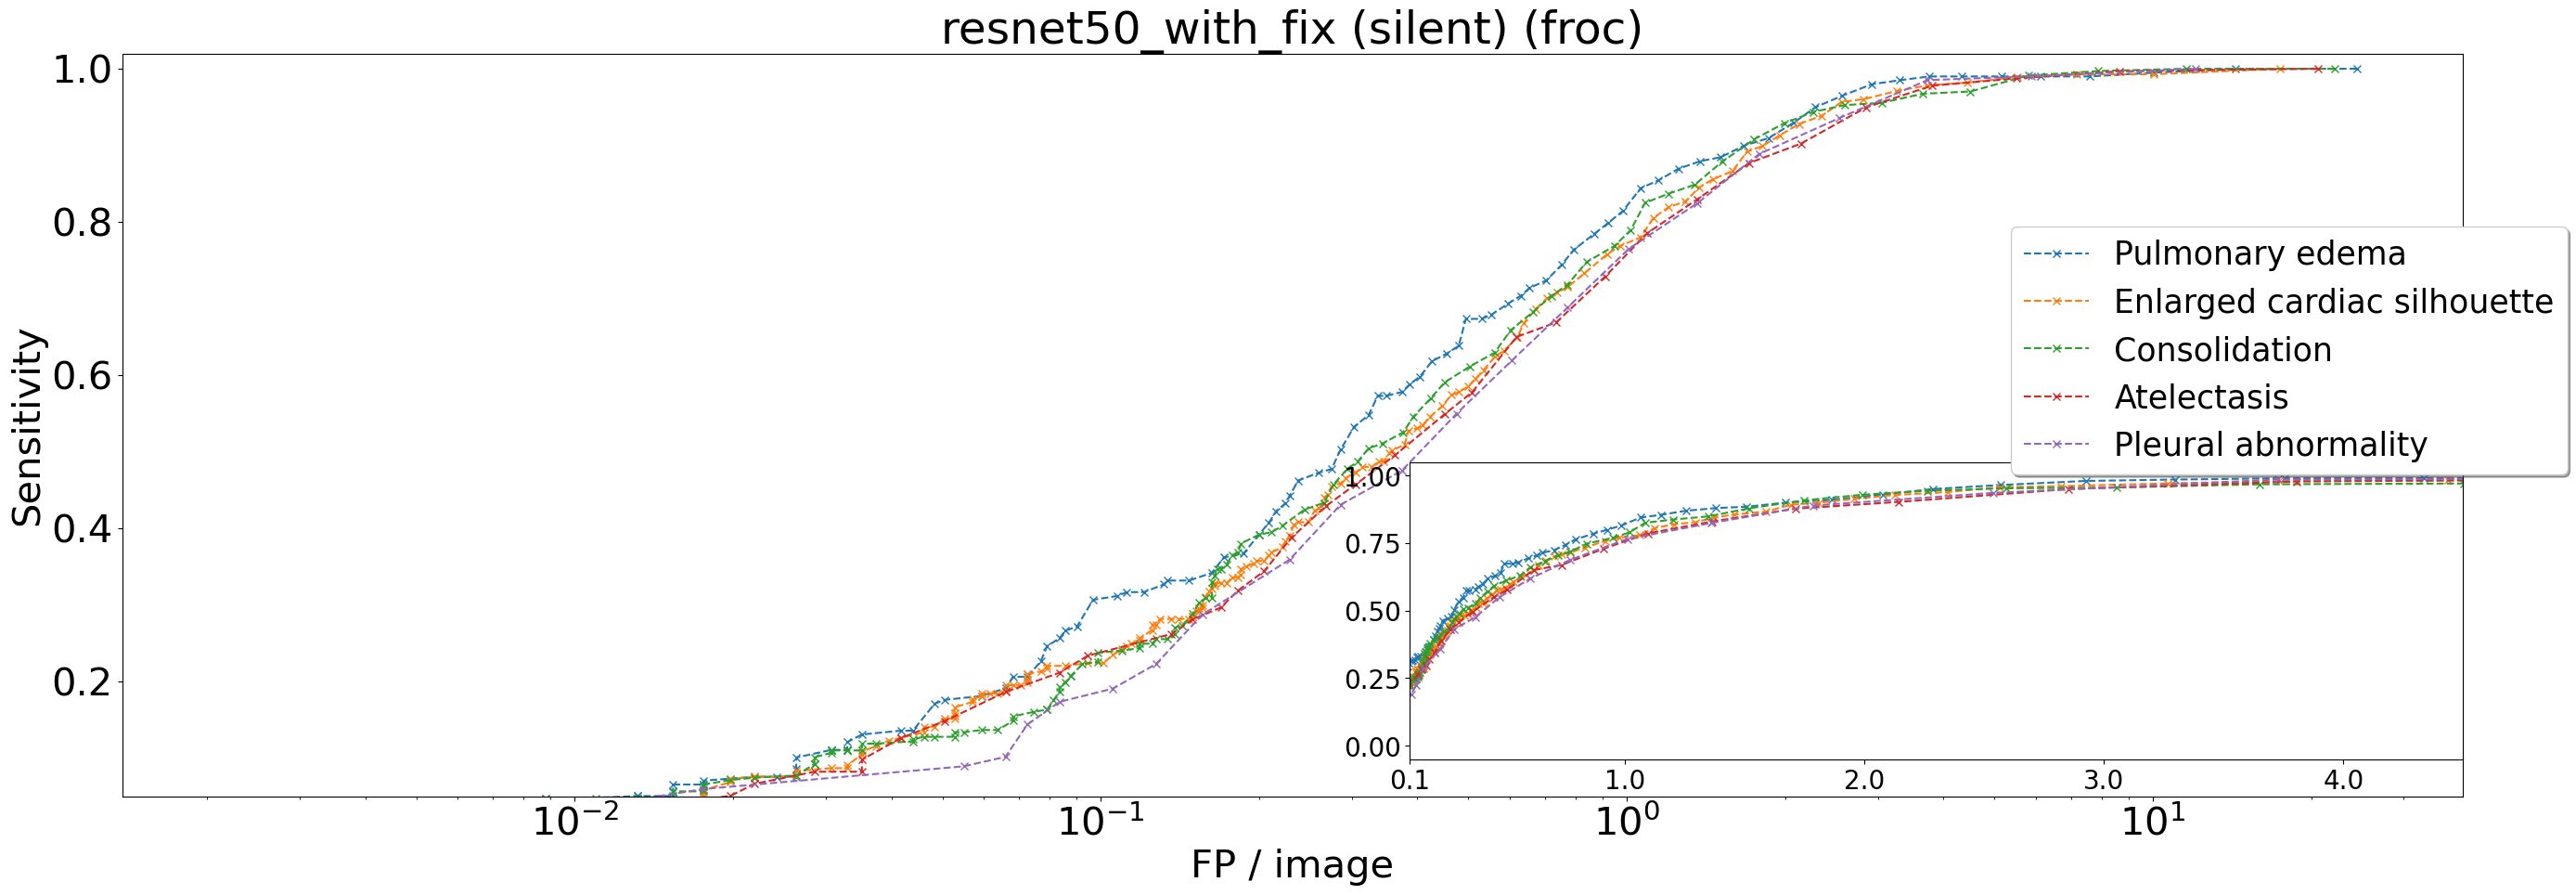

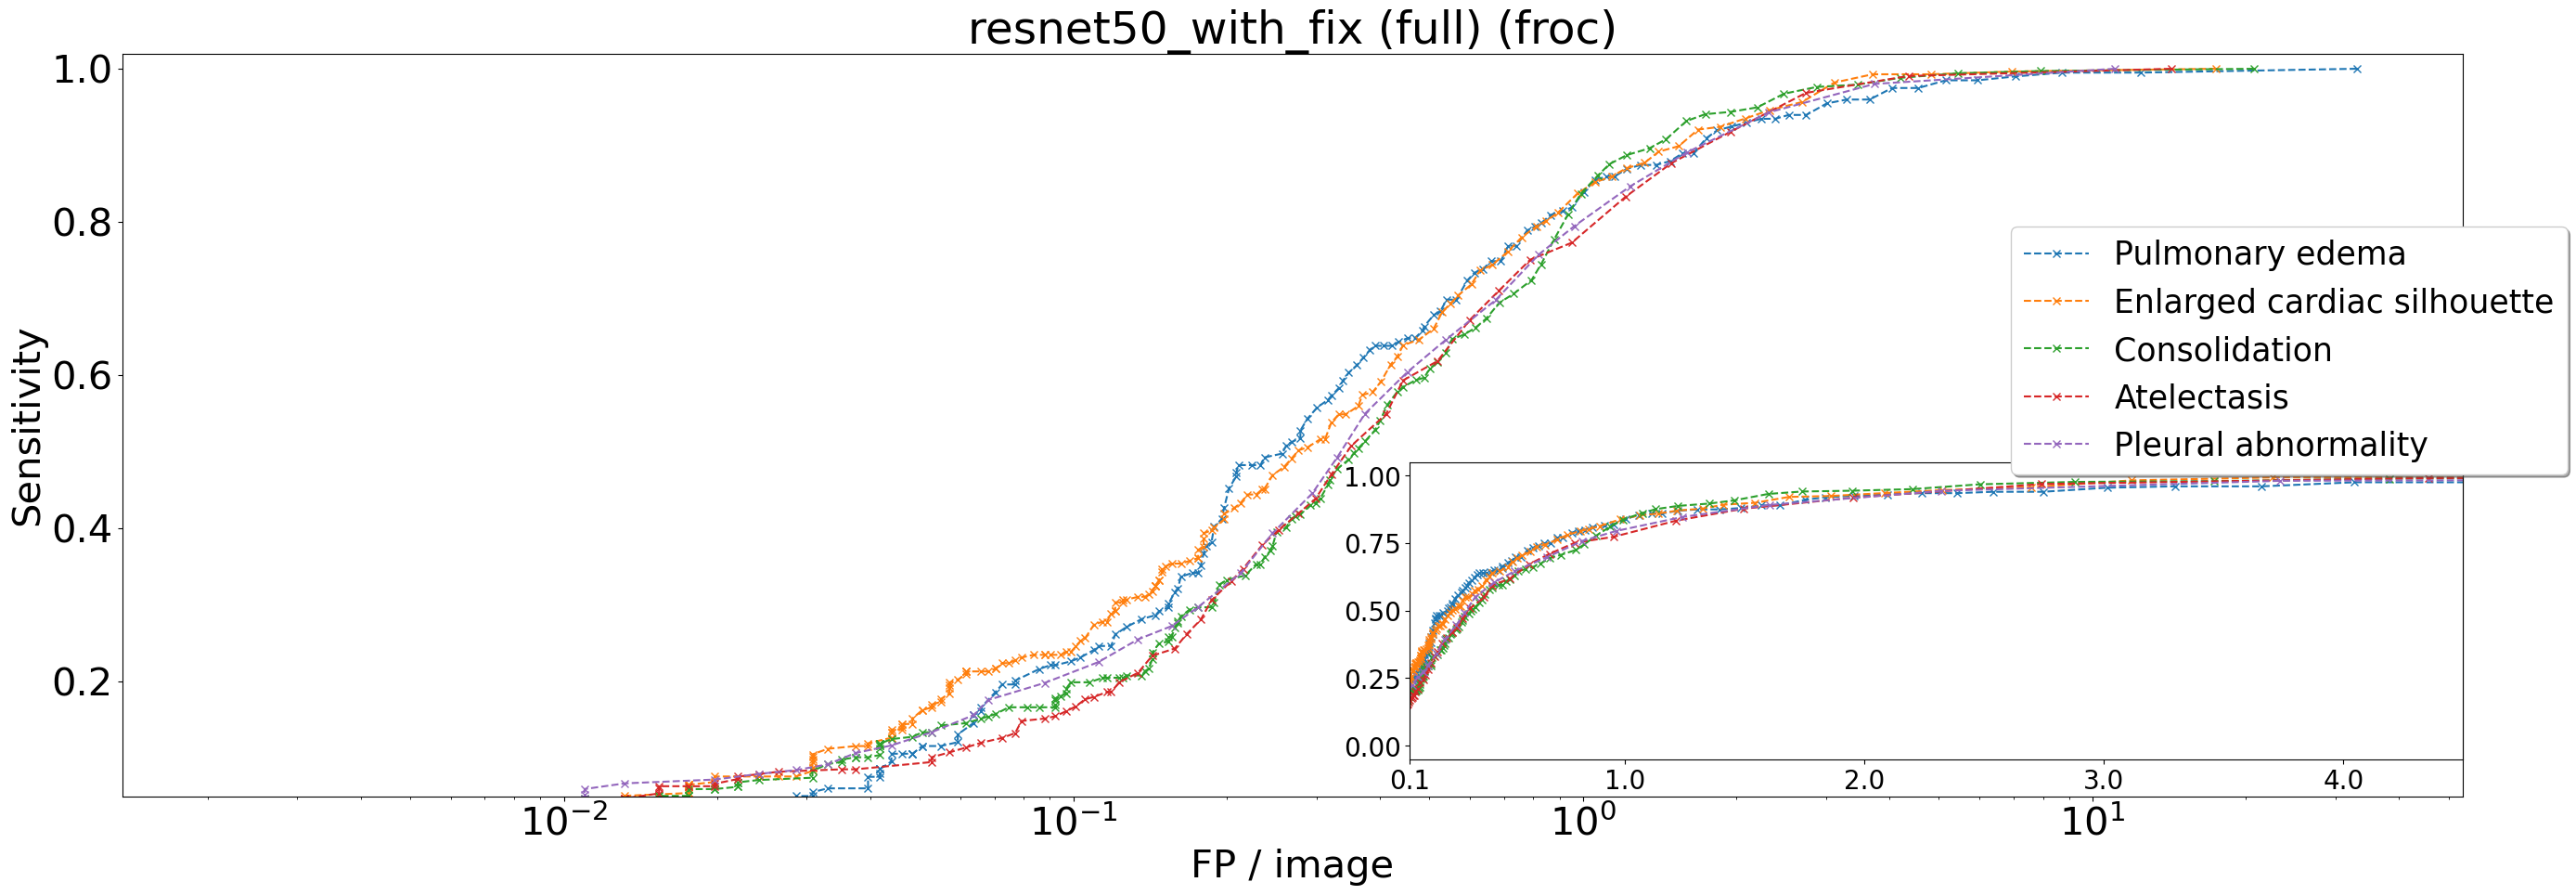

In [5]:
# just generate for the test set.
for select_model in tqdm(
    [
        RetrainedModels.resnet50_with_fix_silent,
        RetrainedModels.resnet50_with_fix_full,
    ]
):
    clear_output()
    for score_thrs in score_thresholds:

        device = clean_memory_get_device()
        reproducibility()

        model, train_info, _, _ = get_trained_model(
            select_model,
            device,
        )
        model = model.to(device)
        model.eval()

        setup = train_info.model_setup
        iou_types = get_iou_types(model, setup)

        dataset_params_dict = {
            "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
            "labels_cols": setup.lesion_label_cols,
            "with_xrays_input": SourceStrs.XRAYS in setup.sources,
            "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
            "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
            "fixations_mode_input": setup.fiaxtions_mode_input,
            "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
            "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
            "fixations_mode_label": setup.fiaxtions_mode_label,
            "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
            "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
            "clinical_numerical_cols": setup.clinical_num,
            "clinical_categorical_cols": setup.clinical_cat,
            "image_size": setup.image_size,
            "image_mean": setup.image_mean,
            "image_std": setup.image_std,
        }

        detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
            dataset_params_dict=dataset_params_dict,
        )

        train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
            train_dataset,
            val_dataset,
            test_dataset,
            batch_size=setup.batch_size,
        )

        train_coco = None
        train_coco, val_coco, test_coco, _ = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            iou_thrs=np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
            use_iobb=True,
            maxDets=[1, 5, 10, 30],
        )

        normal_range_eval_params_dict = get_eval_params_dict(
            detect_eval_dataset,
            iou_thrs=normal_iou_thrs,
        )

        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0
        test_evaluator, _ = evaluate(
            setup=setup,
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=normal_range_eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0.05

        stats, lls_accuracy, nlls_per_image = get_froc_curve(
            dataset=test_dataset,
            dts=test_evaluator["lesion-detection"].all_dts,
            all_gts=test_evaluator["lesion-detection"].all_gts,
            plot_title=naming_map[select_model],
            use_iou=True,
            n_sample_points=200,
            froc_save_folder="./froc_figures",
        )

        all_cat_ids = [None] + [
            detect_eval_dataset.disease_to_idx(d)
            for d in detect_eval_dataset.labels_cols
        ]

        for cat_id in all_cat_ids:
            cat_ids = (
                [
                    detect_eval_dataset.disease_to_idx(d)
                    for d in detect_eval_dataset.labels_cols
                ]
                if cat_id is None
                else [cat_id]
            )

            if not (cat_ids is None):
                normal_range_eval_params_dict["bbox"].catIds = cat_ids

            test_evaluator, _ = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=normal_range_eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
            )

            if cat_id is None:
                disease_str = "all"
            else:
                disease_str = detect_eval_dataset.label_idx_to_disease(cat_id)

            froc_v = get_interpolate_froc(
                stats=stats,
                lls_accuracy=lls_accuracy,
                nlls_per_image=nlls_per_image,
                cat_id=cat_id,
                fps_per_img=[0.5, 1, 2, 4],
                weight=True,
            )

            df = pd.DataFrame(
                [
                    {
                        "num_fps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fps"],  # @all_range, maxDet= p.maxDets[-1]
                        "num_fns": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fns"],
                        "num_tps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_tps"],
                        "coco_states": json.dumps(
                            test_evaluator["lesion-detection"].coco_eval["bbox"].stats
                        ),
                        "Sensitivity@ [avgFP=0.5]": froc_v[0],
                        "Sensitivity@ [avgFP=1]": froc_v[1],
                        "Sensitivity@ [avgFP=2]": froc_v[2],
                        "Sensitivity@ [avgFP=4]": froc_v[3],
                        "mFROC@[0.5,1,2,4]": froc_v.mean(),
                    },
                ]
            )

            df.to_csv(
                os.path.join(
                    "./eval_results",
                    f"{select_model.value}_{disease_str}_{score_thrs}.csv",
                )
            )

            print_title(f"{select_model.value}-{disease_str}")
            print(df)
